### Naive implementation

In [2]:
from itertools import cycle
from math import hypot
from numpy import random
import matplotlib.pyplot as plt

In [3]:
random.seed(0)

In [4]:
def dbscan_naive(P, eps, m, distance):

    NOISE = 0
    C = 0

    # map objects
    visited_points = set()
    clustered_points = set()
    clusters = {NOISE: []}

    # get distance
    def region_query(p):
        return [q for q in P if distance(p, q) < eps]

    def expand_cluster(p, neighbours):
        if C not in clusters:
            clusters[C] = []
        clusters[C].append(p)
        clustered_points.add(p)
        while neighbours:
            q = neighbours.pop()
            if q not in visited_points:
                visited_points.add(q)
                neighbourz = region_query(q)
                if len(neighbourz) > m:
                    neighbours.extend(neighbourz)
            if q not in clustered_points:
                clustered_points.add(q)
                clusters[C].append(q)
                if q in clusters[NOISE]:
                    clusters[NOISE].remove(q)

    for p in P:
        if p in visited_points:
            continue
        visited_points.add(p)
        neighbours = region_query(p)
        if len(neighbours) < m:
            clusters[NOISE].append(p)
        else:
            C += 1
            expand_cluster(p, neighbours)

    return clusters

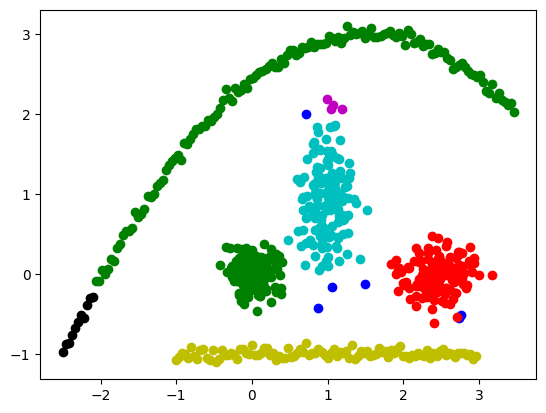

In [5]:
P = [(random.randn()/6, random.randn()/6) for i in range(150)]
P.extend([(random.randn()/4 + 2.5, random.randn()/5) for i in range(150)])
P.extend([(random.randn()/5 + 1, random.randn()/2 + 1) for i in range(150)])
P.extend([(i/25 - 1, + random.randn()/20 - 1) for i in range(100)])
P.extend([(i/25 - 2.5, 3 - (i/50 - 2)**2 + random.randn()/20) for i in range(150)])
clusters = dbscan_naive(P, 0.2, 4, lambda x, y: hypot(x[0] - y[0], x[1] - y[1]))
for c, points in zip(cycle('bgrcmykgrcmykgrcmykgrcmykgrcmykgrcmyk'), clusters.values()):
    X = [p[0] for p in points]
    Y = [p[1] for p in points]
    plt.scatter(X, Y, c=c)
plt.show()

### Find best params

In [6]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from hyperopt import hp, tpe, Trials, fmin

In [7]:
X, y = make_blobs(n_samples=1000, n_features=10, centers=4, cluster_std=1.5)

In [8]:
# setup opt parameters
space = {
    'eps': hp.uniform('eps', 0.01, 0.99),
    'min_samples': hp.randint('min_samples', 1, 11),
}

In [9]:
def objective(params):
    model = DBSCAN(**params)
    labels = model.fit_predict(X)

    unique_labels = set(labels)
    if len(unique_labels) <= 1 or (-1 in unique_labels and len(unique_labels) == 2):
        # if all points from one cluster
        return -np.inf
    
    try:
        score = silhouette_score(X, labels)
    except ValueError:
        return -np.inf

    # minimize target function
    return -score

In [10]:
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

100%|███████████████████████| 50/50 [00:00<00:00, 95.03trial/s, best loss: -inf]


In [11]:
print('Best parameters:', best_params)

Best parameters: {'eps': 0.4869163990658551, 'min_samples': 10}
